# Forecasting Home Prices w/ Zillow Data

## Imports and Custom Functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.ticker as mticks
import matplotlib.dates as mdates
import os
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs
import pmdarima as pm

SEED = 321
np.random.seed(SEED)

plt.rcParams['figure.facecolor']='white'
plt.rcParams['figure.figsize']=(12,4)
sns.set_context('notebook', font_scale=0.9)

In [2]:
def format_xdates(ax, fig=None, xtick_fontweight='bold',
               title= None):
    """Formats x-axis with minor ticks every 3 months, and major 
    ticks every year. Includes different grid options for visibility"""
    # create the locator to place ticks every 3 months.
    loc_3months = mdates.MonthLocator(interval=3)
    fmt_months = mdates.DateFormatter("%b")
    ## for major year ticks
    loc_year = mdates.YearLocator()
    fmt_year = mdates.DateFormatter("%Y")
    
    ## Change the font of the major ticks to stand out
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), 
                       fontweight=xtick_fontweight) 
    
    ## customize minor ticks
    ax.xaxis.set_minor_locator(loc_3months)
    ax.xaxis.set_minor_formatter(fmt_months)
    ## customize major ticks
    ax.xaxis.set_major_locator(loc_year)
    ax.xaxis.set_major_formatter(fmt_year)
    ## Making major/minor gridlines visually distince
    ax.grid(which='minor',axis='x',ls=":")
    ax.grid(which='major',axis='x',color='k')
    if fig is None:
        fig = ax.get_figure()
    ## rotate the dates
    fig.autofmt_xdate(which='major',rotation=90,ha='center')
    return fig,ax

def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)
    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)
    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")
    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)
    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)
    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')
    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )
    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)
    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")
        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 
        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")
    fig.tight_layout()
    
    return fig

## Import and Prep Wide Form Data

In [3]:
df = pd.read_csv('Data/zillow_home_values-zipcode.csv')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27442 entries, 0 to 27441
Columns: 284 entries, RegionID to 30112022
dtypes: float64(275), int64(3), object(6)
memory usage: 59.5+ MB


,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,31012000,...,28022022,31032022,30042022,31052022,30062022,31072022,31082022,30092022,31102022,30112022
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,107261.0,...,261945.0,267644.0,273946.0,280066.0,285121.0,288532.0,290458.0,291103.0,292081.0,292948.0
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,222569.0,...,453150.0,464727.0,478369.0,489712.0,497173.0,499429.0,497572.0,498113.0,500187.0,503109.0
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,90009.0,...,177319.0,179463.0,182812.0,186403.0,189836.0,192064.0,193760.0,195140.0,196787.0,198137.0
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,188096.0,...,570211.0,572145.0,573662.0,576469.0,578706.0,580834.0,581779.0,584566.0,588188.0,590722.0
4,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,275983.0,...,752025.0,757734.0,760336.0,766163.0,771443.0,776607.0,779281.0,782367.0,788211.0,793924.0


In [4]:
states = ['CA','WA','AZ','NV','OR']

statesDF = df[df['State'].isin(states)]
statesDF['State'].unique()

array(['CA', 'WA', 'AZ', 'NV', 'OR'], dtype=object)

In [5]:
statesDF = statesDF.drop(columns=['StateName','RegionID','RegionType'])
meltDF = statesDF.melt(id_vars=['SizeRank','State','RegionName','City','Metro','CountyName'],
                      value_name='Price',
                      var_name='Date')
meltDF

,SizeRank,State,RegionName,City,Metro,CountyName,Date,Price
0,5,CA,90011,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,31012000,143426.0
1,8,CA,91331,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,31012000,144841.0
2,9,CA,90650,Norwalk,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,31012000,163955.0
3,12,CA,90201,Bell,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,31012000,163273.0
4,13,CA,92335,Fontana,"Riverside-San Bernardino-Ontario, CA",San Bernardino County,31012000,110958.0
...,...,...,...,...,...,...,...,...
806020,30657,CA,95950,Grimes,NaN,Colusa County,30112022,313005.0
806021,30657,NV,89041,Pahrump,"Pahrump, NV",Nye County,30112022,414072.0
806022,30657,WA,98623,White Salmon,NaN,Klickitat County,30112022,729920.0
806023,30657,WA,98628,Goldendale,NaN,Klickitat County,30112022,146513.0


In [6]:
meltDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 806025 entries, 0 to 806024
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   SizeRank    806025 non-null  int64  
 1   State       806025 non-null  object 
 2   RegionName  806025 non-null  int64  
 3   City        780725 non-null  object 
 4   Metro       733975 non-null  object 
 5   CountyName  806025 non-null  object 
 6   Date        806025 non-null  object 
 7   Price       699843 non-null  float64
dtypes: float64(1), int64(2), object(5)
memory usage: 49.2+ MB


In [7]:
meltDF['Date'] = pd.to_datetime(meltDF['Date'],format='%d%m%Y')
meltDF.info()
meltDF.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 806025 entries, 0 to 806024
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   SizeRank    806025 non-null  int64         
 1   State       806025 non-null  object        
 2   RegionName  806025 non-null  int64         
 3   City        780725 non-null  object        
 4   Metro       733975 non-null  object        
 5   CountyName  806025 non-null  object        
 6   Date        806025 non-null  datetime64[ns]
 7   Price       699843 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 49.2+ MB


,SizeRank,State,RegionName,City,Metro,CountyName,Date,Price
0,5,CA,90011,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,2000-01-31,143426.0
1,8,CA,91331,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,2000-01-31,144841.0


In [8]:
meltDF.set_index('Date',  inplace=True)
yearsDF = meltDF.loc[pd.IndexSlice['2010':'2020']]
yearsDF

,SizeRank,State,RegionName,City,Metro,CountyName,Price
Date,,,,,,,
2010-01-31,5,CA,90011,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,209250.0
2010-01-31,8,CA,91331,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,257372.0
2010-01-31,9,CA,90650,Norwalk,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,296430.0
2010-01-31,12,CA,90201,Bell,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,271829.0
2010-01-31,13,CA,92335,Fontana,"Riverside-San Bernardino-Ontario, CA",San Bernardino County,156704.0
...,...,...,...,...,...,...,...
2020-12-31,30657,CA,95950,Grimes,NaN,Colusa County,220881.0
2020-12-31,30657,NV,89041,Pahrump,"Pahrump, NV",Nye County,NaN
2020-12-31,30657,WA,98623,White Salmon,NaN,Klickitat County,538209.0


In [9]:
yearsDF.to_csv('Data/data-for-tableau.csv')

In [10]:
resampleDF = yearsDF.groupby('State').resample('Y').mean()
resampleDF.drop(columns=['SizeRank','RegionName'], inplace=True)
resampleDF.head()

C:\Users\austi\AppData\Local\Temp\ipykernel_34644\291707393.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampleDF = yearsDF.groupby('State').resample('Y').mean()
C:\Users\austi\AppData\Local\Temp\ipykernel_34644\291707393.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampleDF = yearsDF.groupby('State').resample('Y').mean()
C:\Users\austi\AppData\Local\Temp\ipykernel_34644\291707393.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which sho

Price
State Date                     
AZ    2010-12-31  169930.889076
      2011-12-31  152272.467002
      2012-12-31  159902.057789
      2013-12-31  183657.225403
      2014-12-31  198551.492521

In [11]:
plot = resampleDF.unstack(level=0)['Price'][states]

def thousands_formatter(x,pos):
    return f'{int(x/1000)}K'

thousFmt = mticks.FuncFormatter(thousands_formatter)

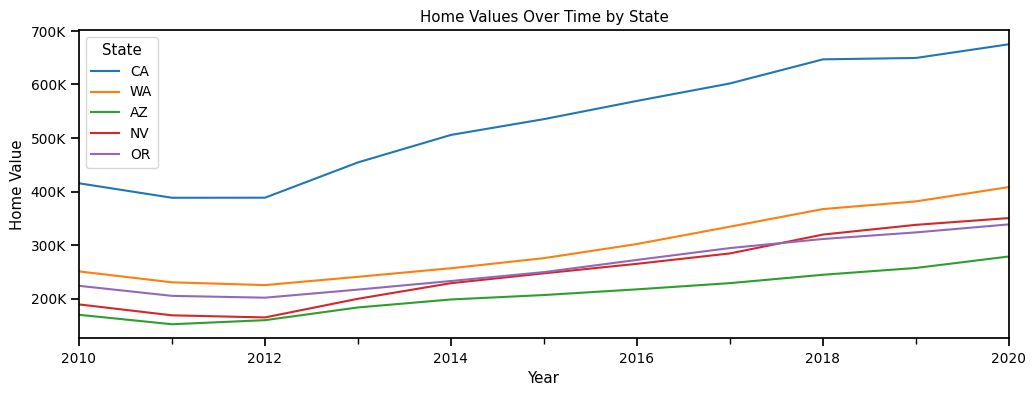

In [12]:
plot.plot()
plt.title('Home Values Over Time by State')
plt.xlabel('Year')
plt.ylabel('Home Value')
plt.gca().yaxis.set_major_formatter(thousFmt);

## State of OR Analysis

### Setting Up Data

In [13]:
states = ['OR']

stateDF = df[df['State'].isin(states)]
stateDF['State'].unique()

array(['OR'], dtype=object)

In [14]:
stateDF = stateDF.drop(columns=['RegionID','RegionType','SizeRank','RegionName','Metro','CountyName','StateName'])
meltsDF = stateDF.melt(id_vars=['City','State'],
                      value_name='Price',
                      var_name='Date')
meltsDF

,City,State,Date,Price
0,Portland,OR,31012000,260209.0
1,Salem,OR,31012000,109851.0
2,Oregon City,OR,31012000,204570.0
3,Hillsboro,OR,31012000,181574.0
4,Eugene,OR,31012000,136799.0
...,...,...,...,...
100370,Winston,OR,30112022,226951.0
100371,Donald,OR,30112022,470690.0
100372,Tillamook,OR,30112022,606334.0
100373,Klamath Falls,OR,30112022,319116.0


In [15]:
meltsDF['Date'] = pd.to_datetime(meltsDF['Date'], format='%d%m%Y')
meltsDF.set_index('Date', inplace=True)
meltsDF.head()

,City,State,Price
Date,,,
2000-01-31,Portland,OR,260209.0
2000-01-31,Salem,OR,109851.0
2000-01-31,Oregon City,OR,204570.0
2000-01-31,Hillsboro,OR,181574.0
2000-01-31,Eugene,OR,136799.0


In [16]:
ORyears = meltsDF.loc[pd.IndexSlice['2000':'2018']]
ORyears.tail()

,City,State,Price
Date,,,
2018-12-31,Winston,OR,163902.0
2018-12-31,Donald,OR,327667.0
2018-12-31,Tillamook,OR,397175.0
2018-12-31,Klamath Falls,OR,NaN
2018-12-31,Tenmile,OR,NaN


In [17]:
ORyears.isna().sum()

City      3192
State        0
Price    16702
dtype: int64

In [18]:
ORyears['Price'].interpolate(method='linear', inplace=True)
ORyears.isna().sum()

C:\Users\austi\AppData\Local\Temp\ipykernel_34644\3170509277.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ORyears['Price'].interpolate(method='linear', inplace=True)


City     3192
State       0
Price       0
dtype: int64

In [19]:
ORyears.drop(columns='City', inplace=True)
resampleOR = ORyears.resample('M').mean()
resampleOR

C:\Users\austi\AppData\Local\Temp\ipykernel_34644\2438956310.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ORyears.drop(columns='City', inplace=True)
C:\Users\austi\AppData\Local\Temp\ipykernel_34644\2438956310.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampleOR = ORyears.resample('M').mean()


,Price
Date,
2000-01-31,160315.820548
2000-02-29,160684.060274
2000-03-31,161030.923288
2000-04-30,160643.001370
2000-05-31,161326.791781
...,...
2018-08-31,310918.158904
2018-09-30,312130.490411
2018-10-31,313293.973973


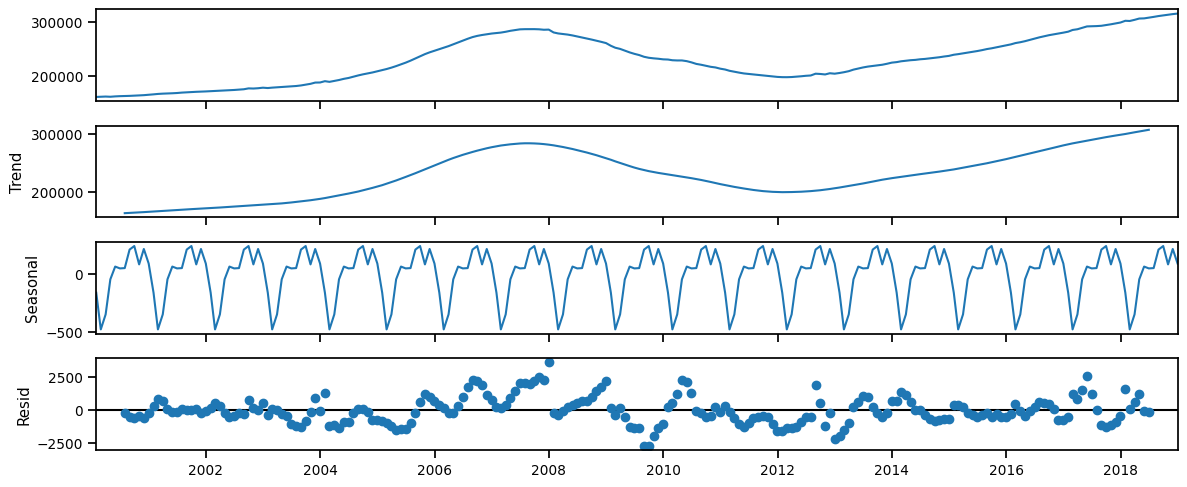

In [20]:
decompOR = tsa.seasonal_decompose(resampleOR)
fig = decompOR.plot()
fig.set_size_inches(12,5)
fig.tight_layout();

        This data does appear to have some seasonality to it so we should test the SARIMA model.

In [21]:
get_adfuller_results(resampleOR)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-1.986536,3,224,0.292507,0.05,False


        The data is not stationary, which is required for our time series analysis. We will need to determine the differences needed.

In [22]:
tsOR = resampleOR['Price']

In [23]:
seasonal_delta = decompOR.seasonal.max() - decompOR.seasonal.min()

print(f"The seasonal component is {seasonal_delta} which is ~{seasonal_delta/(tsOR.max()-tsOR.min()) * 100 :.2f}% of the variation in time series.")

The seasonal component is 717.7413527397341 which is ~0.46% of the variation in time series.


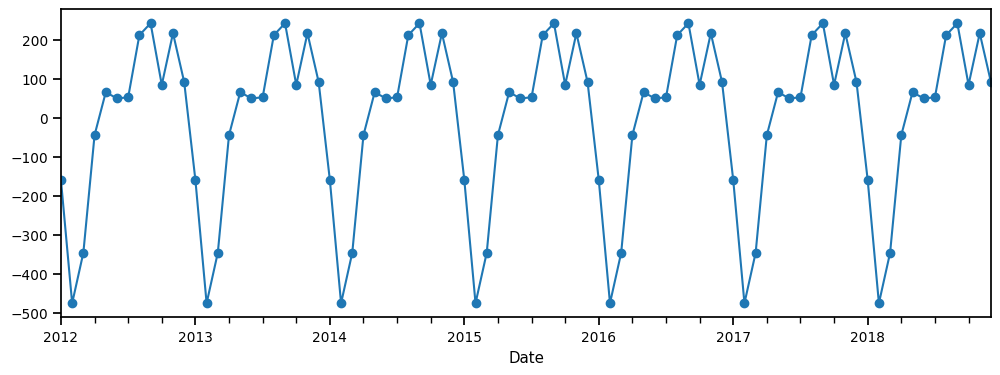

In [24]:
seasonal = decompOR.seasonal
ax = seasonal.loc['2012':'2026'].plot(marker='o')

In [25]:
d = ndiffs(tsOR)
print(f'd = {d}')
D = nsdiffs(tsOR,m=12)
print(f'D = {D}')

d = 2
D = 0


        Based on the ndiffs() and nsdiffs() are d should be 2 and our D should be 0. This will be the amount of times we difference the non-seasonal and seasonal data.

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-17.425972,1,224,0.0,0.05,True


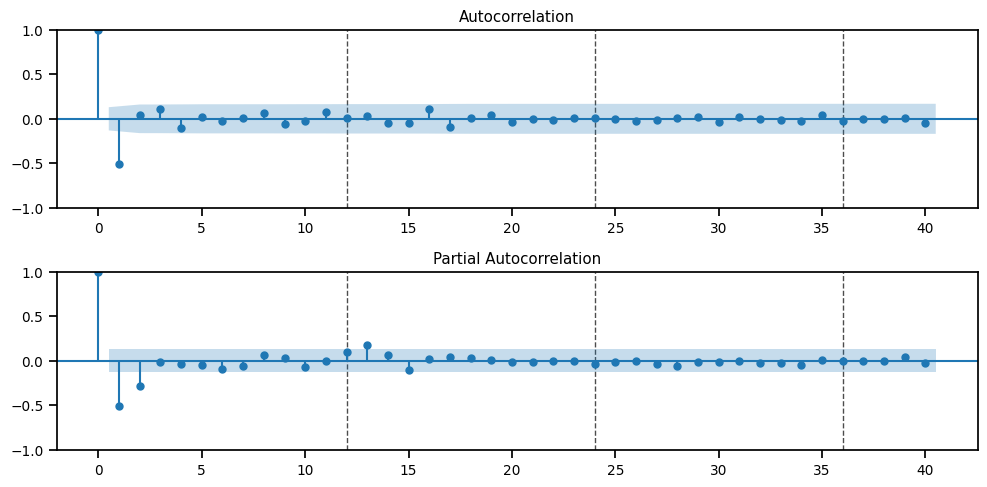

In [26]:
orDiff = tsOR.diff().dropna()
orDiff2 = orDiff.diff().dropna()

plot_acf_pacf(orDiff2, annotate_seas=True,m=12);
get_adfuller_results(orDiff2)

        Both the ACF and PACF seem to have a gradual decrease, so we will test the model SARIMA(1,2,1)(1,0,1)[12]

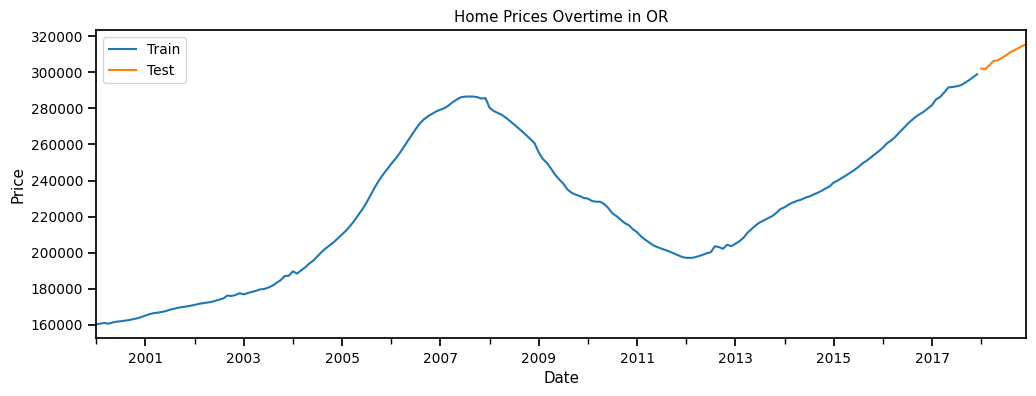

In [27]:
train, test = train_test_split(tsOR, test_size=12)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test', title='Home Prices Overtime in OR',ylabel='Price')
ax.legend();

### SARIMA Model

In [28]:
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 2  # nonseasonal differencing
q = 1  # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                            Price   No. Observations:                  216
Model:             ARIMA(1, 2, 1)x(1, 0, 1, 12)   Log Likelihood               -1777.448
Date:                          Sun, 21 Jan 2024   AIC                           3564.896
Time:                                  14:25:26   BIC                           3581.726
Sample:                              01-31-2000   HQIC                          3571.697
                                   - 12-31-2017                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3515      0.555     -0.633      0.527      -1.440       0.737
ma.L1          0.3237      0.562      0.576      0.565      -0.778       1.425
ar.S.L12       0.3089      2.048      0.151      0.880      -3.705       4.322
ma.S.L12      -0.3043      2.055     -0.148      0.882      -4.332       3.724
sigma2      6.722e+05   2.27e+04     29.617      0.000    6.28e+05    7.17e+05
===================================================================================
Ljung-Box (L1) (Q):                  47.59   Jarque-Bera (JB):               652.36
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                            -1.18
Prob(H) (two-sided):                  0.17   Kurtosis:                        11.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

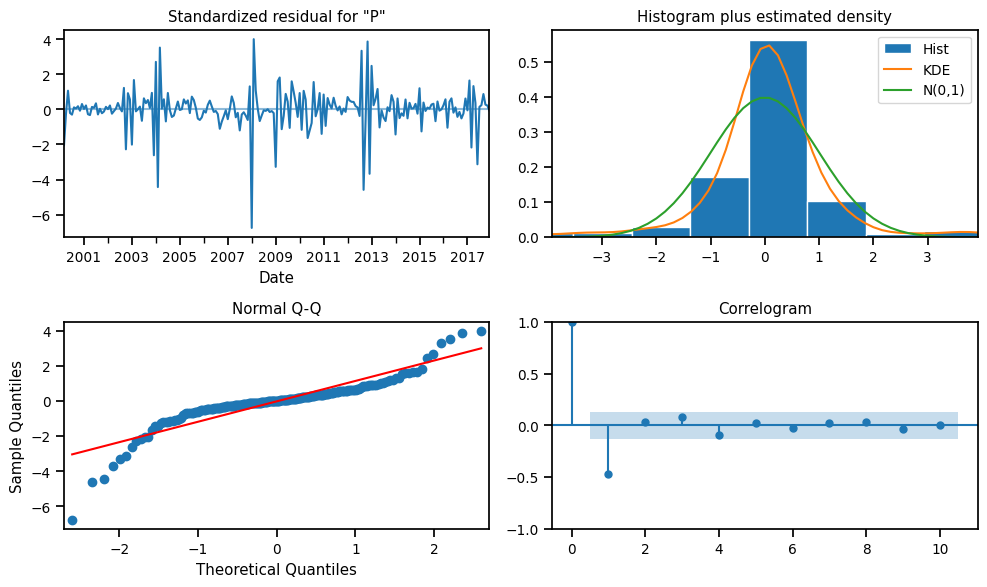

In [29]:
fig = sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout();

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 1,177.637
- MSE = 1,962,441.363
- RMSE = 1,400.872
- R^2 = 0.904
- MAPE = 0.38%


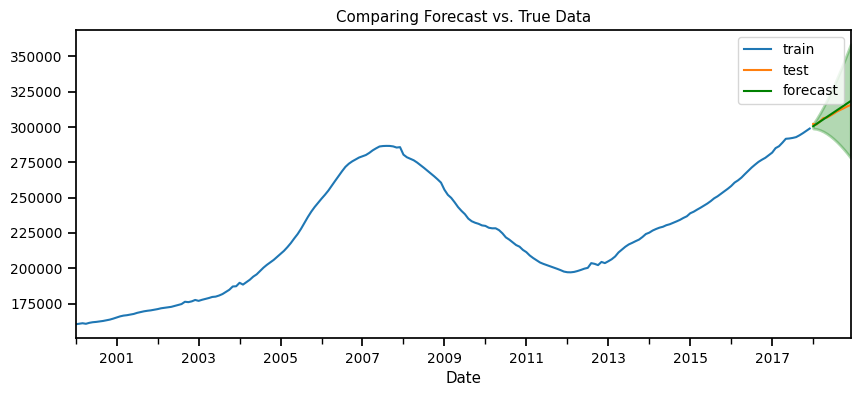

In [30]:
forecastSARIMA = sarima.get_forecast(len(test)).summary_frame()
plot_forecast(train,test,forecastSARIMA);
regression_metrics_ts(test, forecastSARIMA['mean'])

In [31]:
forecastSARIMA

Price,mean,mean_se,mean_ci_lower,mean_ci_upper
2018-01-31,300509.286139,819.900526,298902.310637,302116.261640
2018-02-28,302138.348279,1813.006667,298584.920509,305691.776049
2018-03-31,303758.299961,3025.524438,297828.381029,309688.218893
2018-04-30,305383.998904,4421.645967,296717.732056,314050.265752
2018-05-31,307011.610214,5981.123691,295288.823193,318734.397235
2018-06-30,308627.211038,7688.282665,293558.453911,323695.968164
2018-07-31,310243.868562,9531.492681,291562.486188,328925.250936
2018-08-31,311861.002472,11501.397307,289318.677978,334403.326965
2018-09-30,313481.071581,13590.364176,286844.447260,340117.695903
2018-10-31,315101.666339,15791.979565,284149.955147,346053.377530


#### Auto-Tune SARIMA Model

In [32]:
autoModel = pm.auto_arima(
    train,
    seasonal=True,
    m=12,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=3937.653, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3813.364, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3814.471, Time=0.24 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3808.588, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3840.151, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=3809.983, Time=0.05 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=3810.587, Time=0.16 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=3810.404, Time=0.19 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=3808.621, Time=0.07 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=3812.295, Time=0.50 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=3811.618, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=3799.580, Time=0.45 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=3788.482, Time=0.22 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=3777.828, Time=0.47 sec
 ARIMA(1,1,1)(2,0,0

In [33]:
autoModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  216
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 12)   Log Likelihood               -1883.914
Date:                             Sun, 21 Jan 2024   AIC                           3777.828
Time:                                     14:25:36   BIC                           3794.681
Sample:                                 01-31-2000   HQIC                          3784.637
                                      - 12-31-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     31.3204     18.745      1.671      0.095      -5.418      68.059
ar.L1          0.9225      0.031     29.688      0.000       0.862       0.983
ma.L1         -0.8943      0.034    -26.302      0.000      -0.961      -0.828
ar.S.L12       0.0110      0.011      0.958      0.338      -0.011       0.033
sigma2      2.186e+06      0.000   7.34e+09      0.000    2.19e+06    2.19e+06
===================================================================================
Ljung-Box (L1) (Q):                 134.10   Jarque-Bera (JB):                14.10
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                            -0.58
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.6e+25. Standard errors may be unstable.
"""

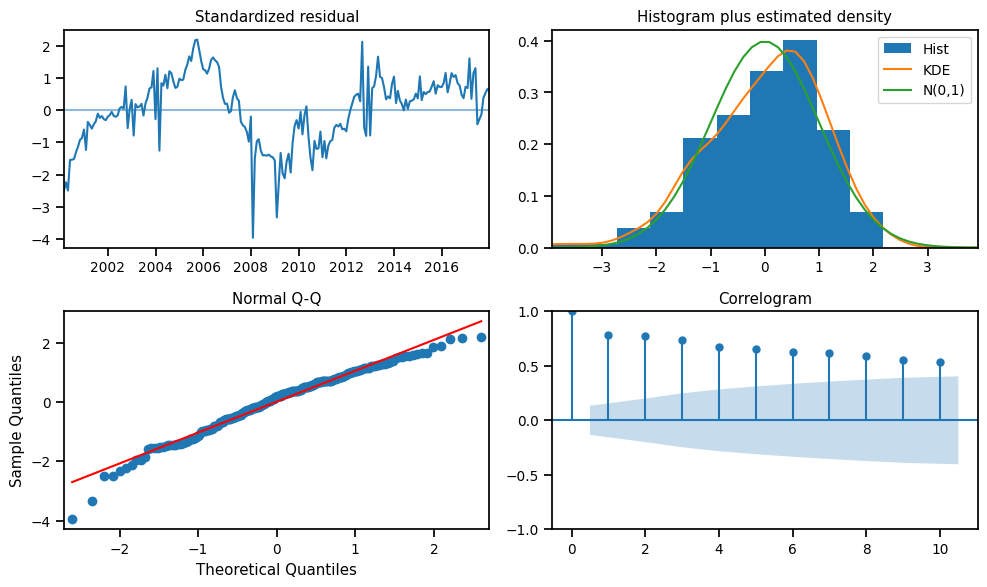

In [34]:
fig = autoModel.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 7,022.062
- MSE = 59,944,713.029
- RMSE = 7,742.397
- R^2 = -1.929
- MAPE = 2.26%


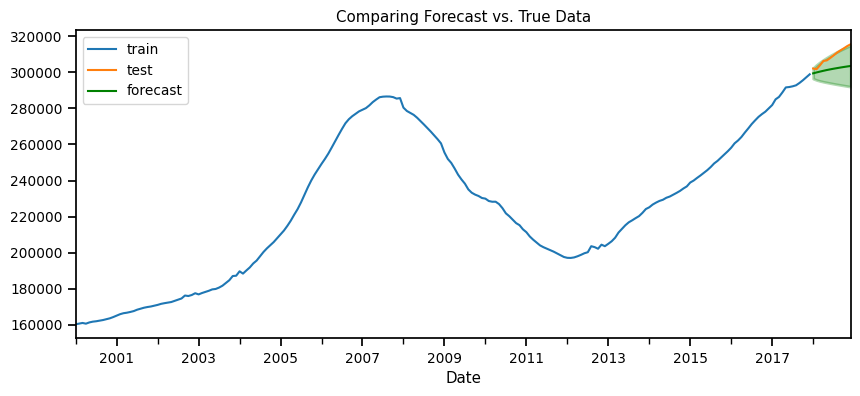

In [35]:
autoModel = tsa.ARIMA(train, order=autoModel.order, seasonal_order=autoModel.seasonal_order).fit()

forecastDF = autoModel.get_forecast(steps=len(test)).summary_frame()
plot_forecast(train, test, forecastDF);
regression_metrics_ts(test, forecastDF['mean'])

In [36]:
forecastDF

Price,mean,mean_se,mean_ci_lower,mean_ci_upper
2018-01-31,299412.002159,1491.650771,296488.420370,302335.583948
2018-02-28,299919.997626,2140.471570,295724.750439,304115.244813
2018-03-31,300382.618314,2658.064177,295172.908258,305592.328370
2018-04-30,300828.570231,3109.897928,294733.282296,306923.858166
2018-05-31,301251.326903,3520.710760,294350.860614,308151.793191
2018-06-30,301627.004744,3902.870389,293977.519346,309276.490143
2018-07-31,301981.869724,4263.534490,293625.495676,310338.243772
2018-08-31,302317.127699,4607.245713,293287.092033,311347.163365
2018-09-30,302639.046326,4937.078555,292962.550169,312315.542482
2018-10-31,302944.118820,5255.216015,292644.084700,313244.152940


        The auto-trained model seems to perform significantly worse than the manual model. So we would want to continue on with the manual model. The largest factor is the negative r2 score on the auto model, indicating some major issues need to be resolved.

### Future Forecast (12 month forecast)

In [37]:
resampleOR.isna().sum()

Price    0
dtype: int64

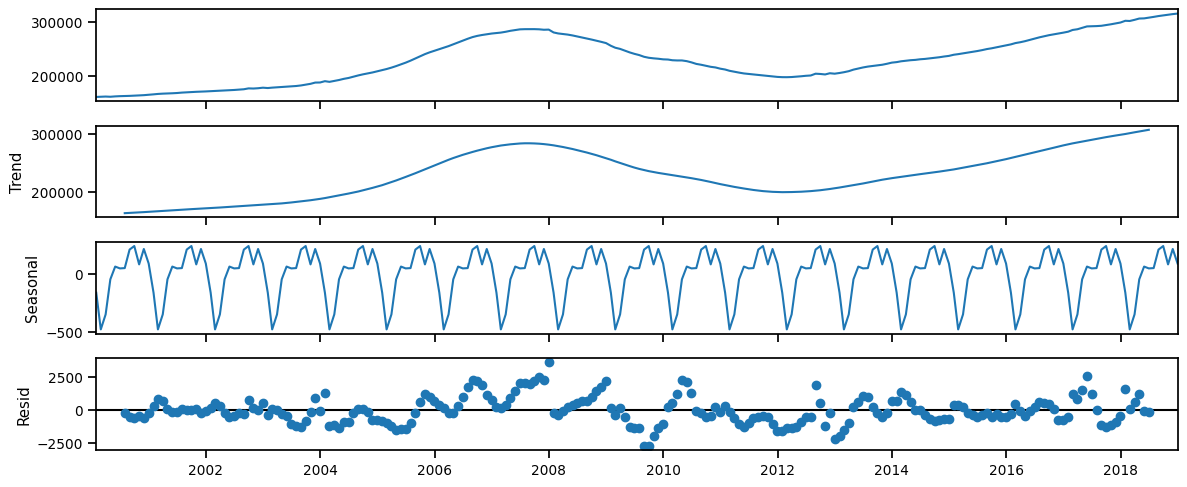

In [38]:
forDecomp = tsa.seasonal_decompose(resampleOR)
fig = forDecomp.plot()
fig.set_size_inches(12,5)
fig.tight_layout();

        There does appear to be some seasonality within the home price peaks and valleys.

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-1.986536,3,224,0.292507,0.05,False


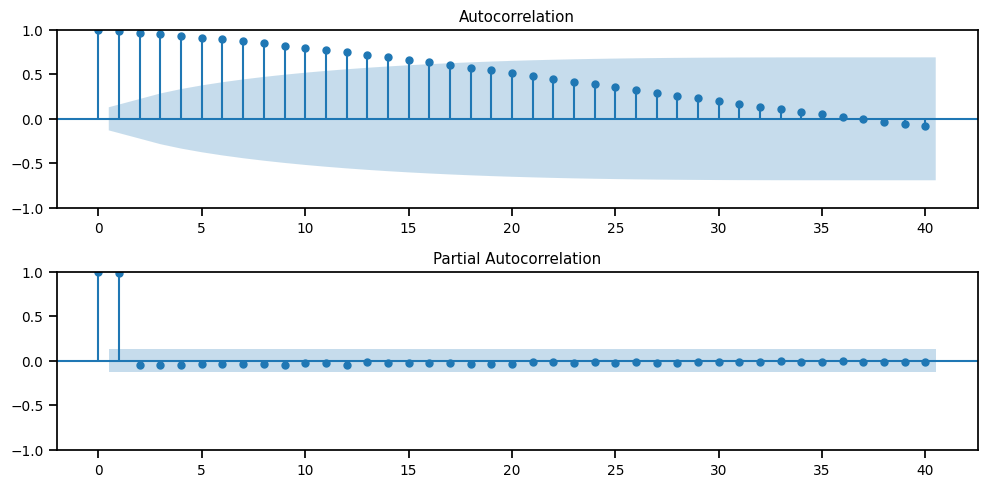

In [39]:
plot_acf_pacf(tsOR, m=12)
get_adfuller_results(tsOR)

        The data is not stationary so I will need to address this.

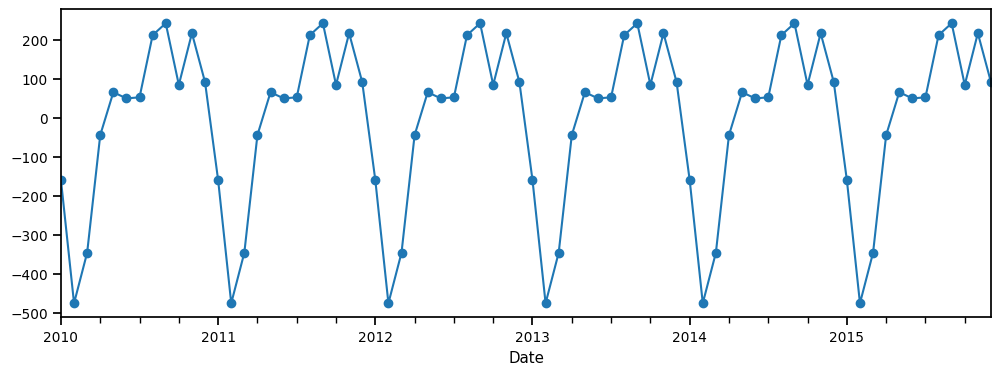

In [40]:
seasonal = forDecomp.seasonal
ax = seasonal.loc['2010':'2015'].plot(marker='o')

        The season is m=12 events long, and appears to be yearly. Now, I want to see how big the season is.

In [41]:
seasonDelta = forDecomp.seasonal.max() - forDecomp.seasonal.min()

print(f'The seasonal component is {seasonDelta :.2f}, which is ~{seasonDelta/(tsOR.max()-tsOR.min())*100 :.2f}% of the variation in time series.')

The seasonal component is 717.74, which is ~0.46% of the variation in time series.


In [42]:
from scipy.signal import find_peaks

peaks, props = find_peaks(seasonal, height=seasonal.max())
pDate = seasonal.index[peaks]
period = pDate[1]-pDate[0]
period

Timedelta('365 days 00:00:00')

        Ok so the season is in fact one year (365 days), now I need to address the staionarity.

In [43]:
d = ndiffs(tsOR)
print(d)
D = nsdiffs(tsOR, m=12)
print(D)

2
0


        Ok, so we need to differentiate our nonsesaonal component two times, and our seasonal component is showing it does not need to be different. So I know my d=2 and D=0.

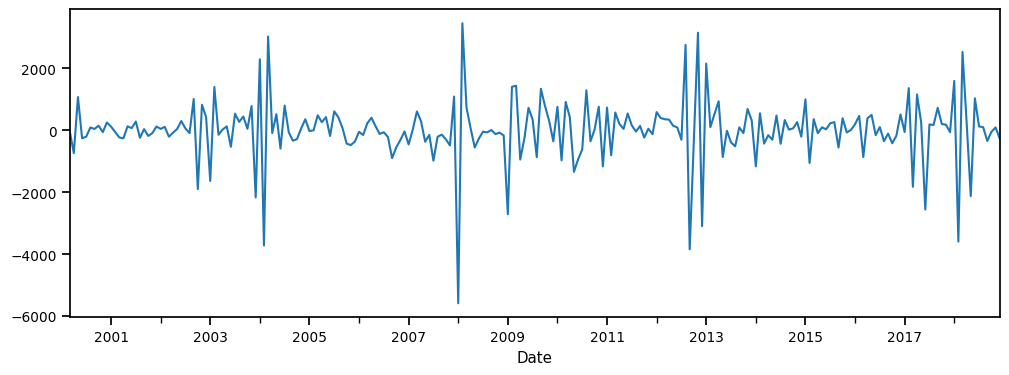

In [44]:
tsORDiff = tsOR.diff().dropna()
tsORDiff2 = tsORDiff.diff().dropna()

tsORDiff2.plot();

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-17.425972,1,224,0.0,0.05,True


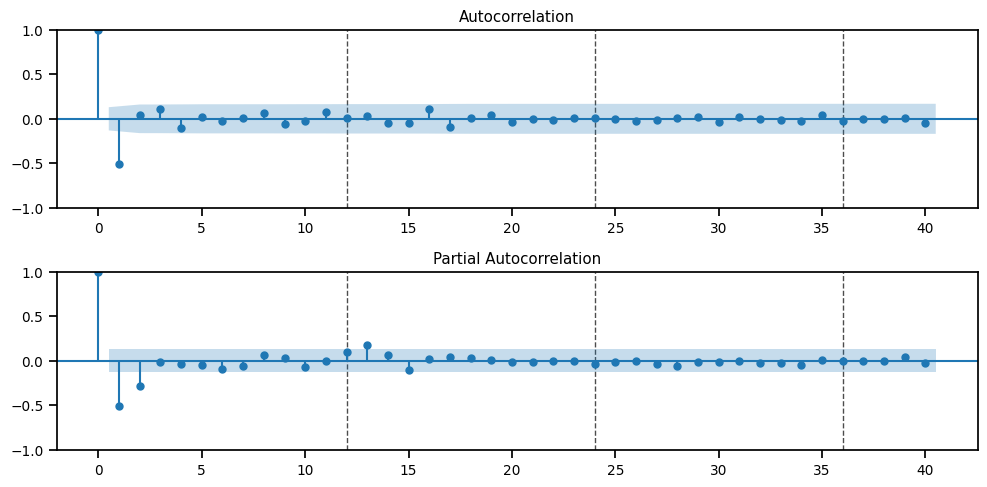

In [45]:
plot_acf_pacf(tsORDiff2, annotate_seas=True, m=12);
get_adfuller_results(tsORDiff2)

        Based on the ACF and PACF plots I can see that the there is a drop on the q lag and a graducal decrease on the p lag. Based on this I will start out with a SARIMA(0,2,1)(0,0,1)[12]

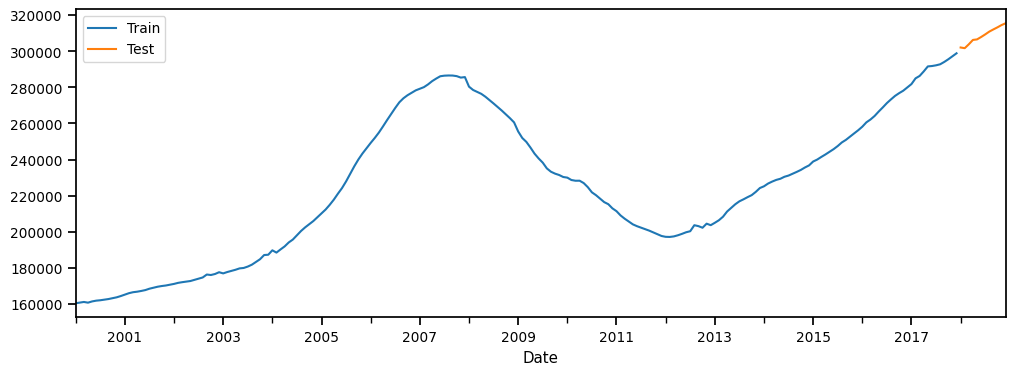

In [46]:
train, test = train_test_split(tsOR,test_size=12)

ax = train.plot(label='Train')
test.plot(ax=ax,label='Test')
ax.legend();

In [47]:
# Orders for non seasonal components
p = 0  # nonseasonal AR
d = 2  # nonseasonal differencing
q = 1  # nonseasonal MA

# Orders for seasonal components
P = 0  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                            Price   No. Observations:                  216
Model:             ARIMA(0, 2, 1)x(0, 0, 1, 12)   Log Likelihood               -1777.025
Date:                          Sun, 21 Jan 2024   AIC                           3560.050
Time:                                  14:25:40   BIC                           3570.148
Sample:                              01-31-2000   HQIC                          3564.131
                                   - 12-31-2017                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0325      0.007     -4.337      0.000      -0.047      -0.018
ma.S.L12       0.0063      0.030      0.211      0.833      -0.052       0.065
sigma2      6.823e+05   2.27e+04     30.117      0.000    6.38e+05    7.27e+05
===================================================================================
Ljung-Box (L1) (Q):                  46.97   Jarque-Bera (JB):               639.42
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.35   Skew:                            -1.18
Prob(H) (two-sided):                  0.21   Kurtosis:                        11.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

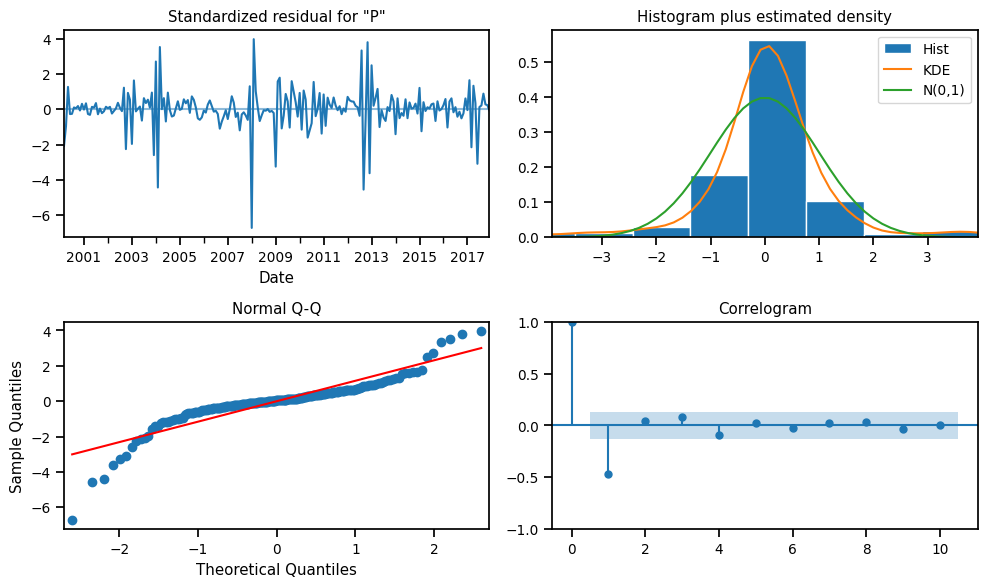

In [48]:
fig = sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 1,168.480
- MSE = 1,931,463.417
- RMSE = 1,389.771
- R^2 = 0.906
- MAPE = 0.38%


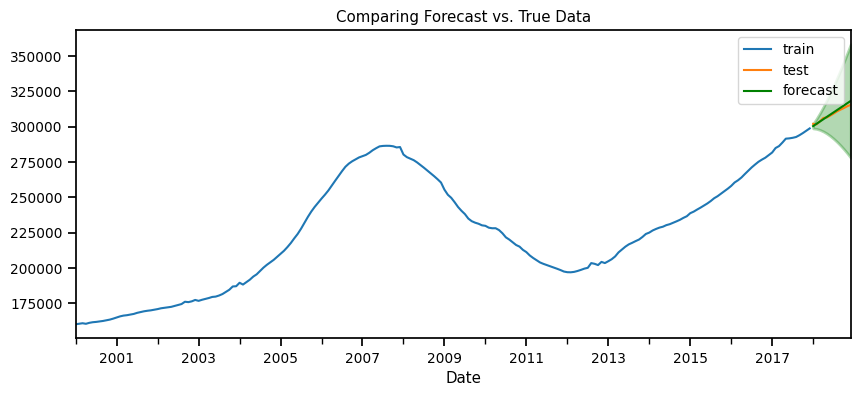

In [49]:
forecast_df = sarima.get_forecast(steps=len(test)).summary_frame()
plot_forecast(train, test, forecast_df);
regression_metrics_ts(test, forecast_df['mean'])

### Test an Auto Trained Model

In [50]:
auto_model = pm.auto_arima(
    train,
    seasonal=True,  
    m=12,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=3937.653, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3813.364, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3814.471, Time=0.24 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3808.588, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3840.151, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=3809.983, Time=0.05 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=3810.587, Time=0.19 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=3810.404, Time=0.21 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=3808.621, Time=0.06 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=3812.295, Time=0.52 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=3811.618, Time=0.06 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=3799.580, Time=0.46 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=3788.482, Time=0.23 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=3777.828, Time=0.48 sec
 ARIMA(1,1,1)(2,0,0

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 7,022.062
- MSE = 59,944,713.029
- RMSE = 7,742.397
- R^2 = -1.929
- MAPE = 2.26%


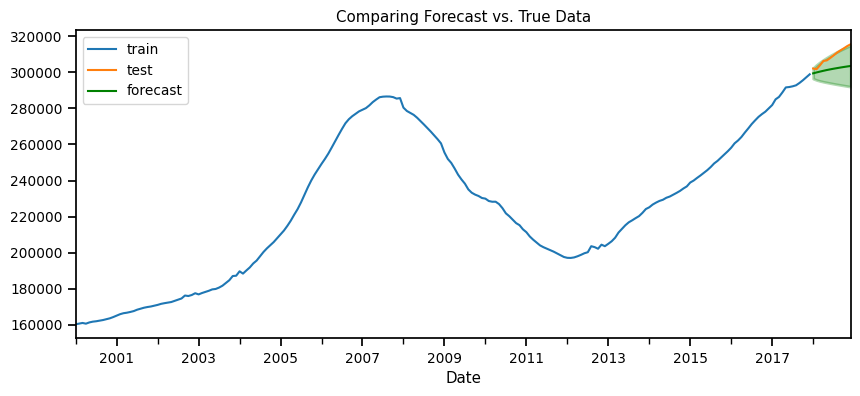

In [51]:
auto_model = tsa.ARIMA(
    train, order=auto_model.order, seasonal_order=auto_model.seasonal_order
).fit()


forecast_df = auto_model.get_forecast(steps=len(test)).summary_frame()
plot_forecast(train, test, forecast_df);
regression_metrics_ts(test, forecast_df['mean'])

        Based on the auto and manual models, I would recommend going with the manual model as it performed better overall on all metrics, and the r2 score on the auto model is negative, hinting there may be an issue with that model.

### Final Model

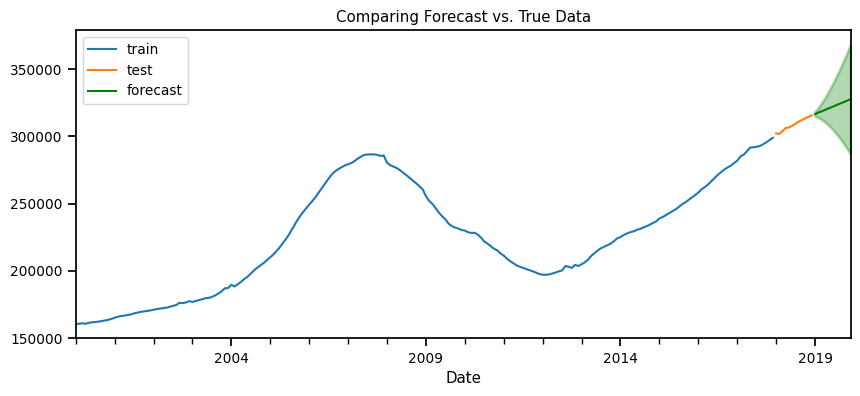

In [52]:
# Orders for non seasonal components
p = 0  # nonseasonal AR
d = 2  # nonseasonal differencing
q = 1  # nonseasonal MA

# Orders for seasonal components
P = 0  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

final_model = tsa.ARIMA(tsOR, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

forecast_df  = final_model.get_forecast(len(test)).summary_frame()
plot_forecast(train,test,forecast_df);

In [53]:
start = forecast_df['mean'].iloc[0]
end = forecast_df['mean'].iloc[-1]
change = end - start
perChange = (change / start) * 100

print(f'Final Count: {end:.2f}\nPerChange: {perChange:.2f}%\nTotal Change: {change:.2f}')

Final Count: 327572.11
PerChange: 3.48%
Total Change: 11019.79


        Based on the forecast, it is projected for homes to have an average cost of $327,572.11 at the end of 12 months (by the end of 2020). The total average increase is forecasted to be $11,019.79 (3.48%).

TABLEAU VIZ: 

https://public.tableau.com/views/WestCoastHomeAnalysis/HosuingPriceStoryWestCoast?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link